### This Notebook currently only runs locally at Mu-En's Laptop
To run it on a different machine, some paths might need to be fixed.

In [1]:
"""Imports"""
import os
import re
import json
from os import listdir
from os.path import isfile, join, dirname
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy

from proseqteleporter.random_sample_generator.random_sample_generator import random_sample_generator
from proseqteleporter.partitioner.compute_best_partitions import compute_best_partitions as compute_best_partitions_shuffle
from proseqteleporter.partitioner.compute_best_partitions import prepare_compute_best_partitions_params
from proseqteleporter.utils.utils import prepare_0idx_mutations


In [ ]:
params = prepare_compute_best_partitions_params(
    input_file_path=r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\hopping_fs_window\input.xlsx"
)

### Run Experiment
Adjust the parameters of the experiment in run_experiment(). Experiment might take VERY long - 15 hour for optimising a 60 aa sequence, 5 cuts using DFS method.

In [ ]:
"""Define function - run_experiment()"""

def run_experiment(mutations_1idx=params['mutations'], s=params['sequence'], generate_random_input=True, number_of_loops=10, supress_output=False):

    print(f'Default Sequence Length = {len(s)}')

    # create output dirs if not exist
    output_dir = join(dirname('__file__'),'output')
    log_dir = join(output_dir,'logs_exp_incl_bad_fs')
    result_dir = join(output_dir, 'results')
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)

    # clean log directory before string the run
    for f in os.listdir(log_dir):
        if not re.search('ipynb_checkpoints',f):
            os.remove(join(log_dir,f))

    res = {}
    for loop in range(0,number_of_loops):
        print(f'--------------------------------------------------------------------------------------------------')
        print(f'|                                    RUN {loop} START                                                 |')
        print(f'--------------------------------------------------------------------------------------------------')
        if generate_random_input:
            # replace sequence and mutations with output of random_sample_generator()
            print('--------------------------------------------------------------------------------------------------')
            print(f'Replacing default sequence and mutations with randomly generated sequence and mutations.')
            print('--------------------------------------------------------------------------------------------------')

            s, mutations_1idx, linked_mutations_1dx = random_sample_generator(
                min_aa_length=30, max_aa_length=60,
                min_number_of_positions=3, max_number_of_positions=6,
                min_variations_per_position=1, max_variations_per_position=19,
                max_positions_per_linked_mutation_set=0,
                max_number_of_mutation_linked_mutation_sets=0
            )

        all_mutations_0idx, linked_mutations_0idx = prepare_0idx_mutations(mutations_1idx, linked_mutations_1dx)

        for search_method in ['DFS','BFS','NFS']:
            updated_params = deepcopy(params)
            updated_params.update(dict(
                mutations_0idx=all_mutations_0idx,
                linked_mutations_0idx=linked_mutations_0idx,
                search_method=search_method,
                sort_by_cost=True,
                partition_search_mode='dist_mut_1',
                select_top_n_partitions=3,
                max_partition_number_checked=100000
            ))
            best_partitions_by_cut_number_shuffle, best_partitions_by_cut_number_file_path_shuffle = compute_best_partitions_shuffle(**params)

            res.update({f'{search_method}_{loop}':best_partitions_by_cut_number_shuffle['total_elapsed_time']})

            output_path = join(result_dir, f'{search_method}_{loop}.json')
            with open(output_path, 'w') as fp:
                json.dump(best_partitions_by_cut_number_shuffle, fp)
                print('--------------------------------------------------------------------------------------------------')
                print(f'Result "{search_method}_{loop}" is exported as: {output_path}')
                print('--------------------------------------------------------------------------------------------------')
    print(res)

In [ ]:
"""Run Experiment"""

run_experiment()

print('==============================================================================================')
print('=                                   RUN COMPLETED!                                           =')
print('==============================================================================================')


### Analyze experiemnt result: Elapsed time using BFS vs DFS vs NFS

"""Define functions used in analysing and plotting results"""

In [2]:
"""Define functions used in analysing and plotting results"""

def filter_res_by_cut_number(cut_number, res_data):

    output = []
    for d in res_data:
        if d['number_of_cuts'] == cut_number:
            output.append(d)
    return output


def normalize_to_bfs(res_data, keep_bfs=False):

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["number_of_cuts"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        time_of_each_method = {d['search_method']: d['elapsed_time'] for d in lst}
        for d in lst:
            out_d = d.copy()
            out_d.update({"normalized_to_bfs":d["elapsed_time"]/time_of_each_method["BFS"]})
            output.append(out_d)

    if not keep_bfs:
        output = [d for d in output if d['search_method'] != 'BFS']

    return output


def scattered_plot(x_axis, res_data, cut_number_range):

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16, 6))
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(24, 6))
    plt.subplots_adjust(wspace=0.5)
    fig.patch.set_facecolor('white')  # Set the background of the figure to white
    colors = sns.color_palette("flare", len(cut_number_range))
    color_map = {i+1:color for i,color in zip(cut_number_range,colors)}
    y_lims = {'DFS':[0.5,1000],
              'NFS':[0.5,1000]}

    for ax, search_method in zip((ax1, ax2), ["DFS", "NFS"]):
    # for ax, search_method in zip((ax1, ax2, ax3), ["DFS", "BFS", "NFS"]):
        normalized_res = normalize_to_bfs(res_data, keep_bfs=True)
        df = pd.DataFrame([d for d in normalized_res if d['search_method'] == search_method and d['number_of_cuts'] in cut_number_range])

        grouped = df.groupby('number_of_fragments')
        for key, group in grouped:
            sns.regplot(ax=ax,
                        x=group['seq_length'],
                        # y=group['elapsed_time'],
                        y=group['normalized_to_bfs'],
                        scatter=True,
                        label=key,
                        color=color_map[key],
                        scatter_kws={'alpha':0.8,'s':5},
                        line_kws={'linewidth':1.5})

        ax.set_ylabel(f"{search_method} Search Time / BFS Search Time")
        # ax.set_ylabel(f"{search_method} Search Time in Min.")
        ax.set_xlabel(str.title(re.sub('_',' ',x_axis)))
        ax.legend(title='Number of Fragments', loc='upper left', ncols=2)
        ax.set_yscale('log')
        ax.set_facecolor('white')  # Set the background of the axes to white
        ax.set_ylim([0.01,1700])
        ax.set_ylim(y_lims[search_method])
        ax.set_title(f'Search Time Improvement per Seq Length and Cut Number \n'
                     f'\n '
                     f'BFS vs. {search_method}')
        # ax.set_title(f'Search Time per Seq Length and Fragment Number \n'
        #      f'\n '
        #      f'{search_method}')

        sel_param = "normalized_to_bfs"
        # sel_param = "elapsed_time"
        max_y = max(df[sel_param].values)
        for idx, (x, y) in enumerate(zip(df[x_axis].values,df[sel_param].values)):
            if y == max_y:
                ax.annotate(f"{round(y, 2)}", (x, y))

    return plt


def jitter_box_plot(x_axis, y_axis, df, my_palette, logy=True):

    plt.figure(figsize=(6, 4))
    if logy:
        plt.yscale('log')
    else:
        plt.yscale('linear')

    # Using seaborn to plot with jitter and boxplot
    sns.boxplot(x=x_axis, y=y_axis, hue='search_method', data=df, palette='dark:white', showfliers = False,
                boxprops=dict(facecolor='white', edgecolor="black"))
    sns.stripplot(x=x_axis, y=y_axis, hue='search_method', data=df, palette=my_palette, dodge=True,
                  jitter=True, alpha=0.5, edgecolor='auto')
    plt.xlabel(str.title(re.sub('_',' ',x_axis)))
    if y_axis == "normalized_to_bfs":
        plt.ylabel(f"Elapsed Time {str.title(re.sub('_',' ',y_axis))}")
    else:
        plt.ylabel(f"{str.title(re.sub('_',' ',y_axis))} in Min.")
    plt.title(f'Jittered Scatter Plot with Boxplot by Search Method and {str.title(re.sub("_"," ",x_axis))}')

    # Adjust legend to avoid duplicate entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Search Method', loc='upper left')

    return plt

## """Import and prepare data"""

In [3]:
"""Import and prepare data"""

result_dirs = ["../output/DFS_BFS_NFS_exp2_incl_bad_fs_result",
               "../output/DFS_BFS_NFS_exp_result"]

result_files = [join(result_dir, f)
                for result_dir in result_dirs
                for f in listdir(result_dir) if isfile(join(result_dir, f)) and re.search('DFS|BFS|NFS',f)]

res_data = []
for file_path in result_files:
    name = re.search("[NBD]FS_\d",file_path).group()
    with open(file_path, 'r') as fp:
        res_dict = json.load(fp)
        for res_per_cut in res_dict["best_partitions_by_cut_number"]:
            res_dict_ = res_dict.copy()
            res_dict_.update({
                'search_method':re.sub("_\d","",name),
                'seq_length':len(res_dict["sequence"]),
                'mutation_positions':len(res_dict["mutations"]),
                'number_of_cuts':res_per_cut['number_of_cuts'],
                'number_of_fragments':res_per_cut['number_of_cuts']+1,
                'elapsed_time':res_per_cut['elapsed_time']/60
                             })
            res_dict_.pop("best_partitions_by_cut_number", None)
            res_dict_.pop("mutations", None)
            res_data.append(res_dict_)


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../output/DFS_BFS_NFS_exp2_incl_bad_fs_result'

In [ ]:
"""Import and prepare data"""
from proseqteleporter.utils.utils import compute_lib_complexity

parent_dirs = [
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost_min_dna_len_0\fix_complexity_diff_muts_1M",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost_min_dna_len_0\fix_complexity_diff_muts_10k",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost_min_dna_len_0\fix_complexity_diff_muts_10B",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost_min_dna_len_0\fix_complexity_diff_muts_100M",
]

res_data = []
count = 0
for parent_dir in parent_dirs:
    result_dirs = [d for d in listdir(parent_dir) if not isfile(join(parent_dir, d))]
    print(result_dirs)

    for d in result_dirs:
        if re.search('checkpoint',d):
            continue
        param_file = join(parent_dir, d, "results", "params_dist_mut_1.json")
        with open(param_file, 'r') as fp:
            param = json.load(fp)
        mutations_0idx = param['mutations_0idx']
        linked_mutations_0idx = param['linked_mutations_0idx']
        assembly_cond = re.sub("^.*FileS[0-9][0-9]_|[.xlsx]","",param["fidelity_data_path"])
        # assembly_cond = param["fidelity_data_path"]
        diversity = compute_lib_complexity(mutations=mutations_0idx, linked_mutations=linked_mutations_0idx)

        result_files = [join(parent_dir, d, "results", f)
                        for f in listdir(join(parent_dir, d, "results")) if re.search('\dfrags',f)]
        # print(result_files)

        for file_path in result_files:
            count +=1
            with open(file_path, 'r') as fp:
                res_per_cut = json.load(fp)

                res_dict_ = {}
                number_checked = res_per_cut["number_of_partitions_checked"]
                uq_number_checked = res_per_cut["num_of_checked_unique_partitions"]
                hard_constraint_violations = sum([v for v in res_per_cut["hard_constraint_violations"].values()])
                if len(res_per_cut["sel_partitions"]) > 0:
                    ligation_fidelity = res_per_cut["sel_partitions"][0]["ligation_fidelity"]
                    fragment_length_unevenness = res_per_cut["sel_partitions"][0]["fragment_length_unevenness"]
                    cost = res_per_cut["sel_partitions"][0]["cost"]
                else:
                    print(file_path)
                    print(res_per_cut["hard_constraint_violations"])
                    continue
                    # ligation_fidelity = fragment_length_unevenness = cost = float("nan")
                res_dict_.update({
                    'f':file_path,
                    'partition_search_method':"distribute mut and only keep the best",
                    'assembly_condition': assembly_cond,
                    'sequence':param['s'],
                    'complexity': diversity,
                    'seq_length':len(param["s"]),
                    'mutation_positions':len(mutations_0idx),
                    'mutation_variations':sum([len(mut['aa']) for mut in mutations_0idx]),
                    'number_of_cuts':res_per_cut['number_of_cuts'],
                    'number_of_fragments':res_per_cut['number_of_cuts']+1,
                    'elapsed_time':res_per_cut['elapsed_time'],
                    "ligation_fidelity":ligation_fidelity,
                    "fragment_length_unevenness":fragment_length_unevenness,
                    "cost":cost/0.06*0.1,
                    "base_count":cost/0.06,
                    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5204324/
                    "number_of_partitions_checked":number_checked,
                    "num_of_checked_unique_partitions":uq_number_checked,
                    "pass_constraint_percentage": (number_checked-hard_constraint_violations)/number_checked * 100
                                 })
                res_data.append(res_dict_)
                res_dict_cp_ = res_dict_.copy()
                # res_dict_cp_.update({"cost":cost/0.06*0.18})
                # res_data.append(res_dict_cp_)
print(count)
df = pd.DataFrame([d for d in res_data if d['partition_search_method'] == "distribute mut and only keep the best"])
df

## """Plotting - Jitter + Box Plots"""

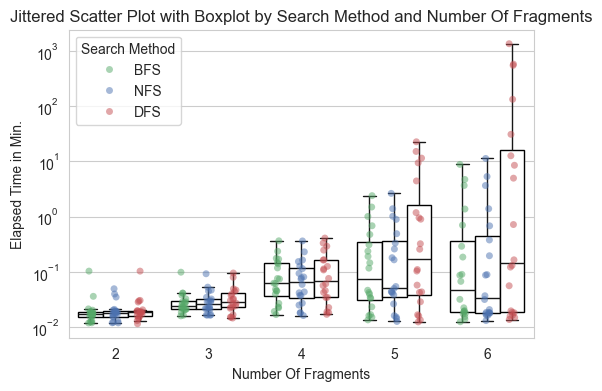

In [159]:
"""Plotting - Jitter + Box Plots"""

my_palette = sns.color_palette(["#55a868","#4c72b0","#c44e52"])

# for x_axis in ['number_of_fragments','seq_length']:
for x_axis in ['number_of_fragments']:
    # for y_axis in ["elapsed_time", "normalized_to_bfs"]:
    for y_axis in ["elapsed_time"]:
        if y_axis == "normalized_to_bfs":
            df = pd.DataFrame(normalize_to_bfs(res_data, keep_bfs=True))
        else:
            df = pd.DataFrame(res_data)
        df['search_method'] = pd.Categorical(df['search_method'], ["BFS", "NFS", "DFS"])
        df = df.sort_values("search_method")
        plt = jitter_box_plot(x_axis, y_axis, df, my_palette, logy=True)
        plt.show()


## """Plotting - Scatter Plots"""

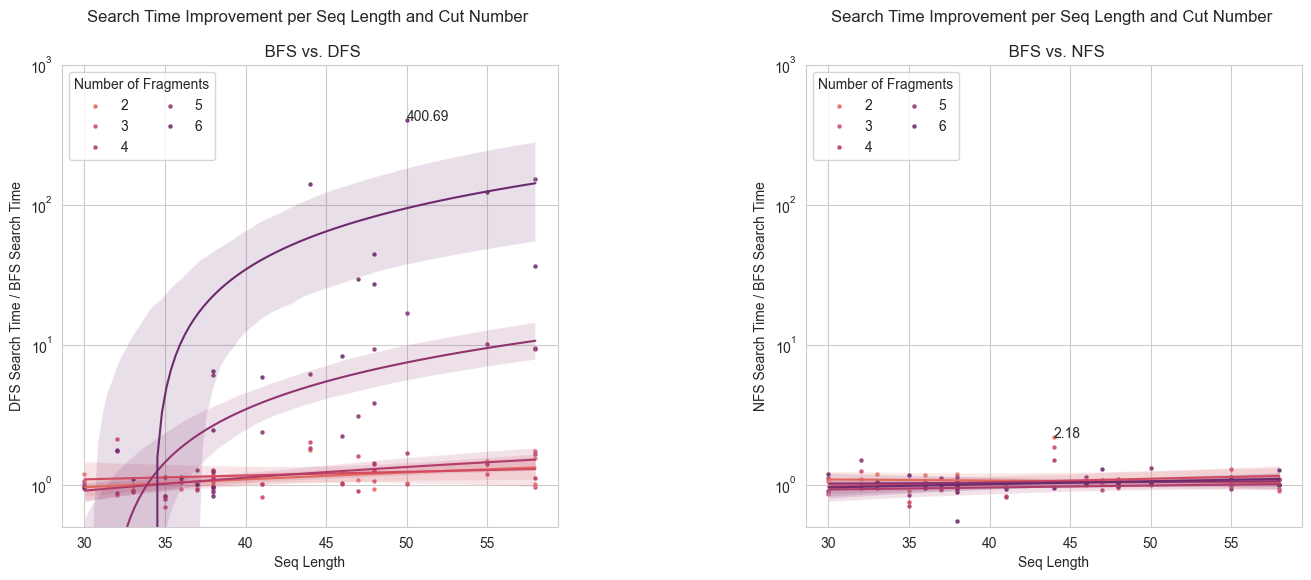

In [171]:
"""Plotting - Scatter Plots"""

plt = scattered_plot(x_axis='seq_length', res_data=res_data, cut_number_range=range(0,6))
plt.show()